In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary
from torchviz import make_dot

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import logging

In [65]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Data Importing

In [66]:
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

In [67]:
# df = pl.read_csv("./.data/train_pp_fe.csv")
# df = df.drop(["id", "time", "hour"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/train_pp_fe.csv")

In [68]:
# df = pl.read_csv("./.data/test_pp_fe.csv")
# df = df.drop(["id", "time", "hour"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/test_pp_fe.csv")

In [69]:
# df = pl.read_csv("./.data/train_pp.csv")
# df = df.drop(["id", "time", "hour_of_day"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/train_pp.csv")

In [70]:
# df = pl.read_csv("./.data/test_pp.csv")
# df = df.drop(["id", "time", "hour_of_day"] + [col for col in df.columns if col.startswith("p_num_p")])
# df.write_csv("./.data/test_pp.csv")

In [71]:
df = pd.read_csv("./.data/train_pp_fe.csv")
df.drop(columns=["id"], inplace=True)

In [72]:
print(df)

         bg-5:55   bg-5:50   bg-5:45   bg-5:40   bg-5:35   bg-5:30   bg-5:25  \
0      -1.457519 -1.457525 -1.347369 -1.237367 -1.125705 -1.058866 -0.993040   
1       0.238889  0.239117  0.297732  0.356476  0.414769  0.473156  0.629338   
2       0.671307  0.671594  0.661152  0.650809  0.639595  0.595274  0.551552   
3      -0.027214 -0.027023 -0.093430 -0.159996 -0.226401 -0.148534 -0.070729   
4      -0.093740 -0.093558  0.073022  0.239853  0.406443  0.606376  0.807132   
...          ...       ...       ...       ...       ...       ...       ...   
177019 -0.293317 -0.293163 -0.293173 -0.259958 -0.226401 -0.159635 -0.059617   
177020  0.272152  0.272384  0.272764  0.273174  0.273212  0.273327  0.273748   
177021  1.236776  1.037537  0.971863  0.972910  0.906056  0.839509  0.740459   
177022  0.139100  0.106047  0.172893  0.206533  0.306520  0.406547  0.473767   
177023  0.504992  0.638327  0.705539  0.673023  0.606288  0.573071  0.507104   

         bg-5:20   bg-5:15   bg-5:10  .

In [73]:
for col in df.columns:
    print(col)

bg-5:55
bg-5:50
bg-5:45
bg-5:40
bg-5:35
bg-5:30
bg-5:25
bg-5:20
bg-5:15
bg-5:10
bg-5:05
bg-5:00
bg-4:55
bg-4:50
bg-4:45
bg-4:40
bg-4:35
bg-4:30
bg-4:25
bg-4:20
bg-4:15
bg-4:10
bg-4:05
bg-4:00
bg-3:55
bg-3:50
bg-3:45
bg-3:40
bg-3:35
bg-3:30
bg-3:25
bg-3:20
bg-3:15
bg-3:10
bg-3:05
bg-3:00
bg-2:55
bg-2:50
bg-2:45
bg-2:40
bg-2:35
bg-2:30
bg-2:25
bg-2:20
bg-2:15
bg-2:10
bg-2:05
bg-2:00
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-5:55
insulin-5:50
insulin-5:45
insulin-5:40
insulin-5:35
insulin-5:30
insulin-5:25
insulin-5:20
insulin-5:15
insulin-5:10
insulin-5:05
insulin-5:00
insulin-4:55
insulin-4:50
insulin-4:45
insulin-4:40
insulin-4:35
insulin-4:30
insulin-4:25
insulin-4:20
insulin-4:15
insulin-4:10
insulin-4:05
insulin-4:00
insulin-3:55
insulin-3:50
insulin-3:45
insulin-3:40
insulin-3:35
insulin-3:30
insulin-3:25
insulin-3:20
insulin-

### Data Splitting

In [74]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [75]:
print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (123916, 441)
Validation Shape: (26554, 441)
Test Shape: (26554, 441)


### Dataset and DataLoader

In [ ]:
class GDataset(Dataset):
    def __init__(self, df):
        self.n_samples = len(df)
        data = df.values
        self.seq_data = data[:, :432].astype(np.float32).reshape(self.n_samples, 6, 72)
        self.eng_data = data[:, 433:441].astype(np.float32)
        self.targets = data[:, 432].astype(np.float32)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.seq_data[idx], self.eng_data[idx], self.targets[idx]

In [77]:
train_dataset = GDataset(train_df)
val_dataset = GDataset(val_df)
test_dataset = GDataset(test_df)

In [78]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [79]:
class Chomp(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

In [80]:
class MultiScaleTemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation, dropout, kernel_sizes=[3, 5, 7]):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernel_sizes:
            padding = (k - 1) * dilation
            branch = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=k, padding=padding, dilation=dilation),
                Chomp(padding),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.branches.append(branch)
        self.conv1x1 = nn.Conv1d(out_channels * len(kernel_sizes), out_channels, kernel_size=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        branch_outputs = [branch(x) for branch in self.branches]
        out = torch.cat(branch_outputs, dim=1)
        out = self.conv1x1(out)
        out = self.relu(out)
        out = self.dropout(out)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

In [81]:
class MultiScaleTCN(nn.Module):
    def __init__(self, num_inputs, num_channels, dropout=0.2, kernel_sizes=[3, 5, 7]):
        super(MultiScaleTCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            dilation = 2 ** i
            layers.append(MultiScaleTemporalBlock(in_channels, out_channels, dilation, dropout, kernel_sizes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [82]:
class TCN(nn.Module):
    def __init__(self, seq_in_channels, tcn_channels, dropout, engineered_dim, fc_hidden_dim, kernel_sizes=[3, 5, 7]):
        super(TCN, self).__init__()
        self.tcn = MultiScaleTCN(num_inputs=seq_in_channels, num_channels=tcn_channels,
                                dropout=dropout, kernel_sizes=kernel_sizes)
        self.engineered_net = nn.Sequential(
            nn.Linear(engineered_dim, fc_hidden_dim),
            nn.ReLU(),
            nn.Linear(fc_hidden_dim, fc_hidden_dim),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(tcn_channels[-1] + fc_hidden_dim, fc_hidden_dim),
            nn.ReLU(),
            nn.Linear(fc_hidden_dim, 1)
        )

    def forward(self, x_seq, x_eng):
        out_seq = self.tcn(x_seq)
        out_seq = torch.mean(out_seq, dim=2)
        out_eng = self.engineered_net(x_eng)
        x_cat = torch.cat([out_seq, out_eng], dim=1)
        out = self.fc(x_cat)
        return out.squeeze(1)

In [83]:
model = TCN(seq_in_channels=6, tcn_channels=[128, 128, 128],
            dropout=0.2, engineered_dim=8, fc_hidden_dim=128, kernel_sizes=[3, 5, 7])
model.to(device)

TCN(
  (tcn): MultiScaleTCN(
    (network): Sequential(
      (0): MultiScaleTemporalBlock(
        (branches): ModuleList(
          (0): Sequential(
            (0): Conv1d(6, 128, kernel_size=(3,), stride=(1,), padding=(2,))
            (1): Chomp()
            (2): ReLU()
            (3): Dropout(p=0.2, inplace=False)
          )
          (1): Sequential(
            (0): Conv1d(6, 128, kernel_size=(5,), stride=(1,), padding=(4,))
            (1): Chomp()
            (2): ReLU()
            (3): Dropout(p=0.2, inplace=False)
          )
          (2): Sequential(
            (0): Conv1d(6, 128, kernel_size=(7,), stride=(1,), padding=(6,))
            (1): Chomp()
            (2): ReLU()
            (3): Dropout(p=0.2, inplace=False)
          )
        )
        (conv1x1): Conv1d(384, 128, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
        (downsample): Conv1d(6, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Mult

#### Model Summary

In [84]:
dummy_seq = torch.randn(1, 6, 72).to(device)
dummy_eng = torch.randn(1, 8).to(device)

In [85]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq, dummy_eng]))

Model Summary:
Layer (type:depth-idx)                        Output Shape              Param #
TCN                                           [1]                       --
├─MultiScaleTCN: 1-1                          [1, 128, 72]              --
│    └─Sequential: 2-1                        [1, 128, 72]              --
│    │    └─MultiScaleTemporalBlock: 3-1      [1, 128, 72]              62,080
│    │    └─MultiScaleTemporalBlock: 3-2      [1, 128, 72]              295,424
│    │    └─MultiScaleTemporalBlock: 3-3      [1, 128, 72]              295,424
├─Sequential: 1-2                             [1, 128]                  --
│    └─Linear: 2-2                            [1, 128]                  1,152
│    └─ReLU: 2-3                              [1, 128]                  --
│    └─Linear: 2-4                            [1, 128]                  16,512
│    └─ReLU: 2-5                              [1, 128]                  --
├─Sequential: 1-3                             [1, 1]       

#### Model Computational Graph

In [86]:
dummy_output = model(dummy_seq, dummy_eng)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


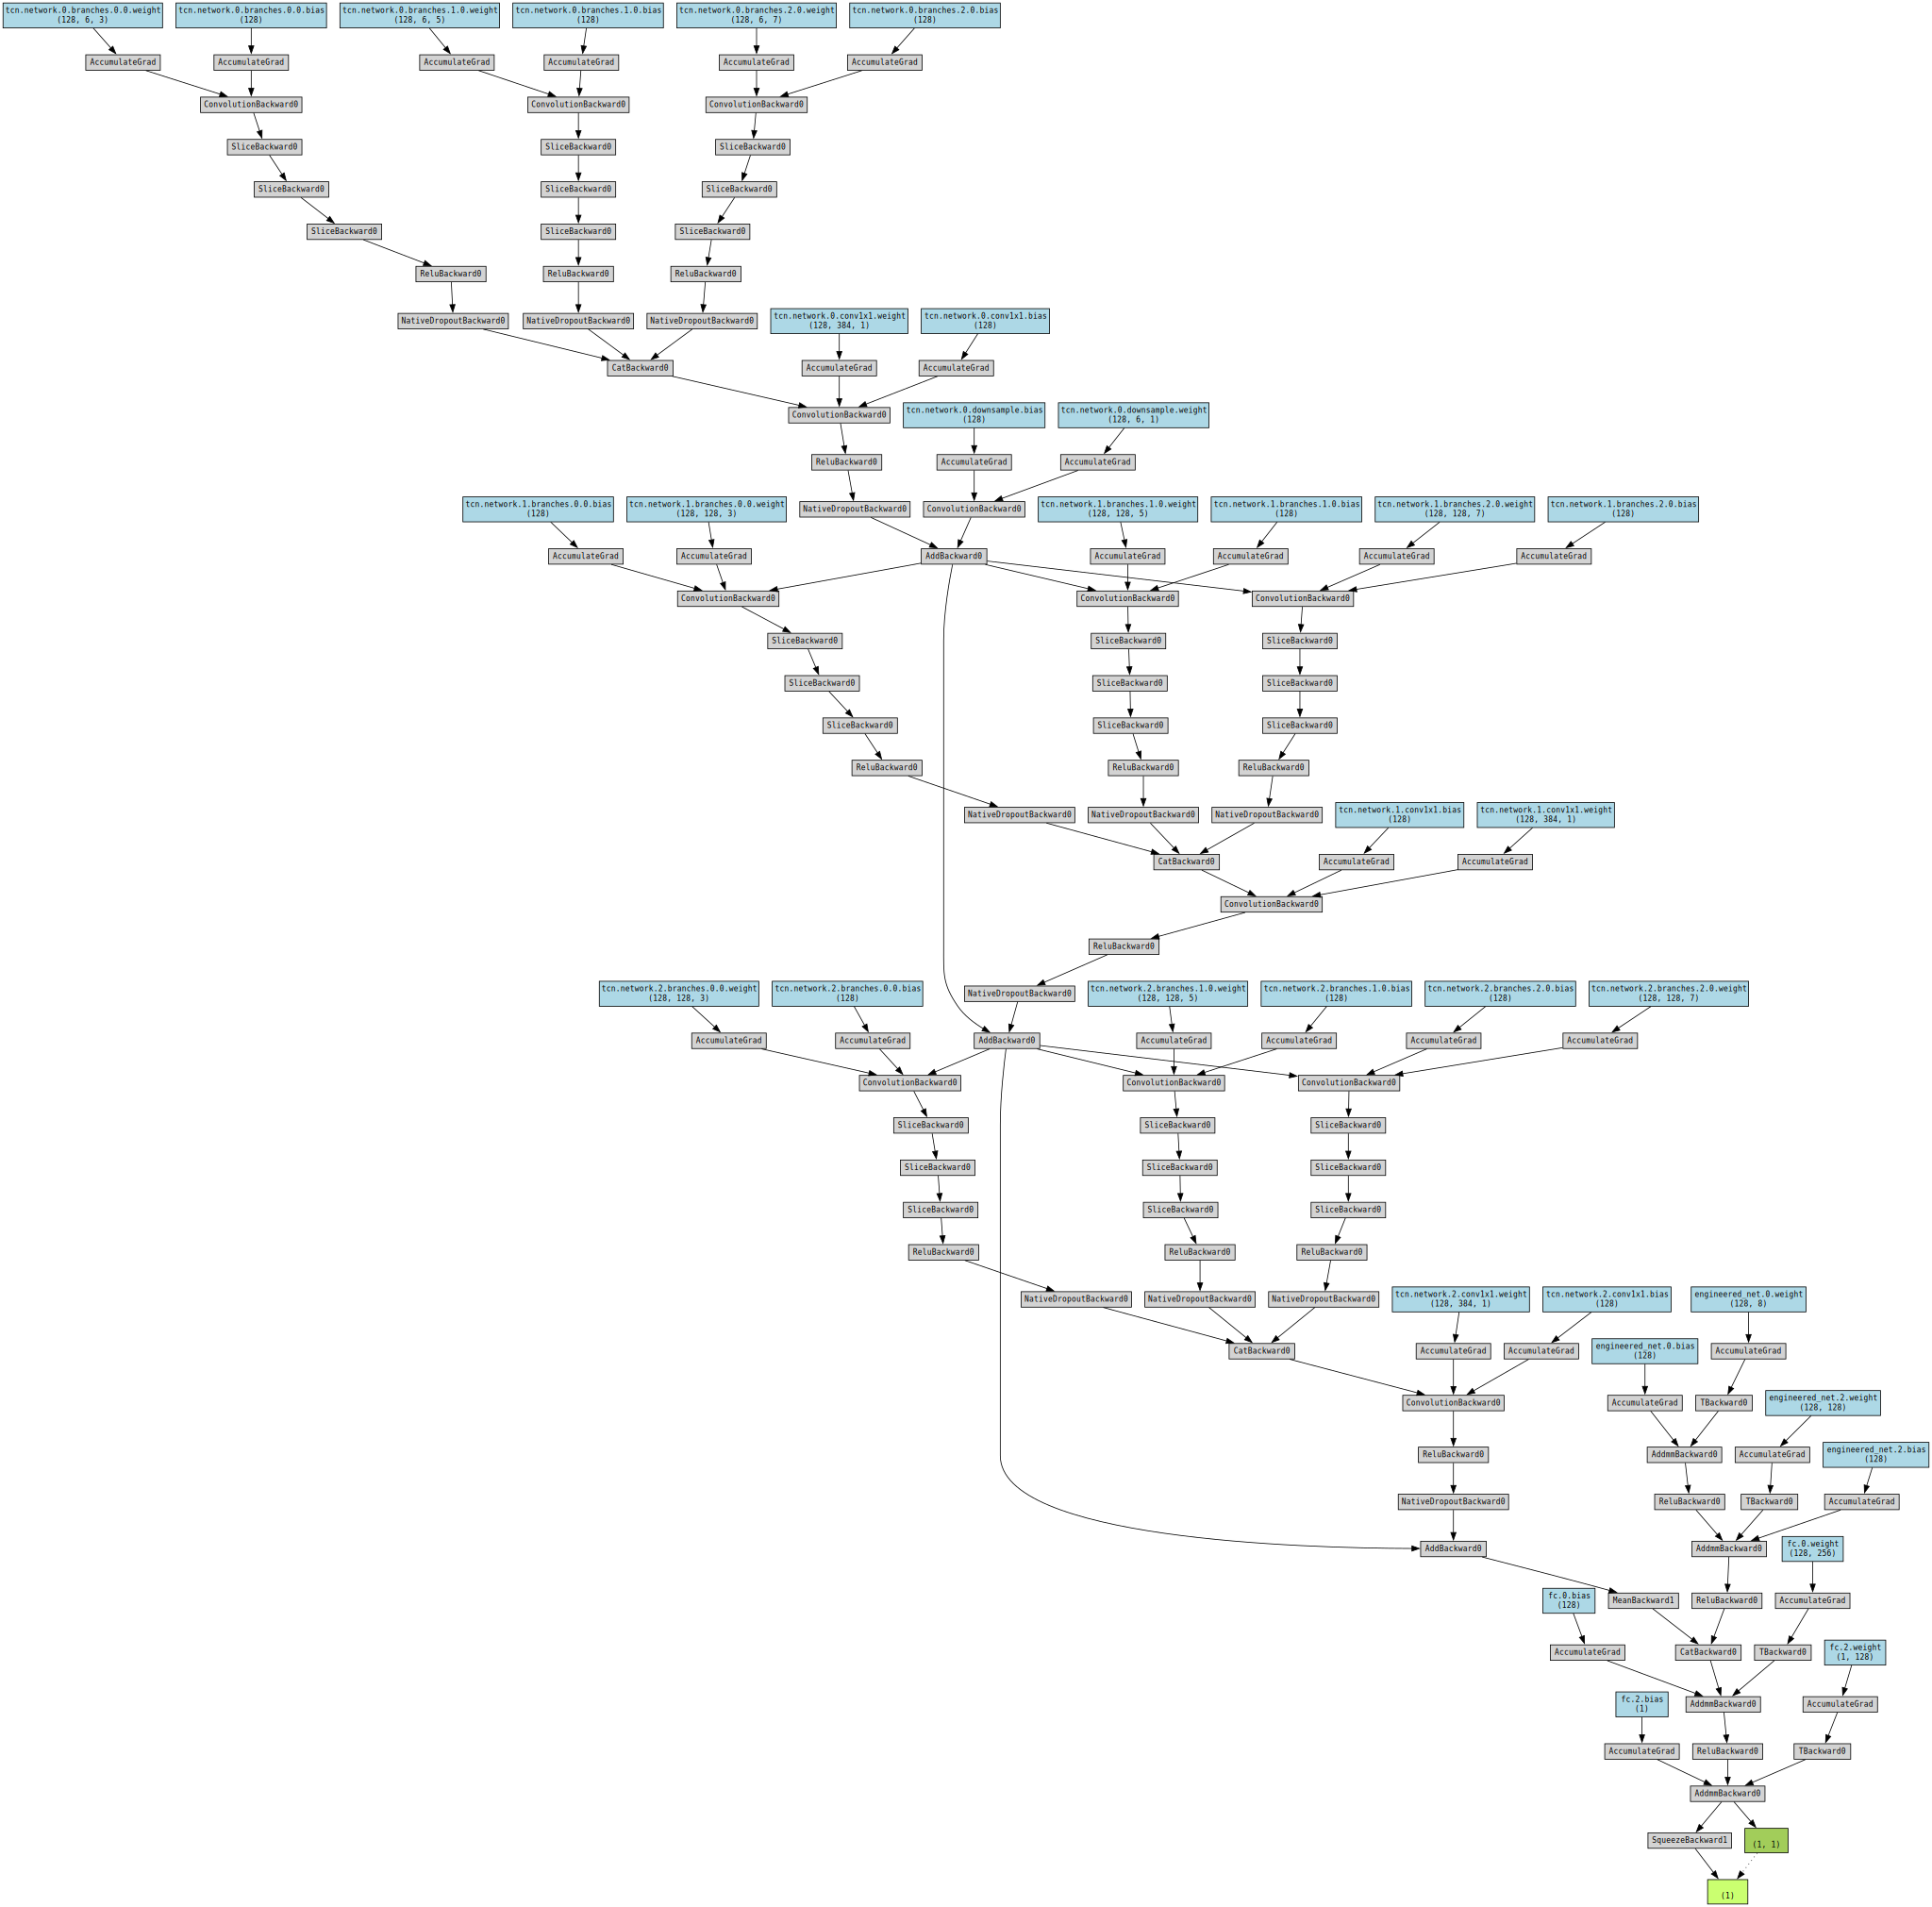

In [87]:
print("Model Computational Graph:")
display(dot)

### Training

In [88]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [89]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), './.export/checkpoint-fe.pt')
        self.val_loss_min = val_loss

In [90]:
early_stopping = EarlyStopping(patience=5, verbose=True)
num_epochs = 100
train_losses = []
val_losses = []

In [91]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#             profile_memory=True,
#             record_shapes=True) as prof:

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0

#         for x_seq, x_eng, targets in tqdm(train_loader, desc=f"Epoch: {epoch+1} (Train)"):
#             x_seq = x_seq.to(device)
#             x_eng = x_eng.to(device)
#             targets = targets.to(device)

#             optimizer.zero_grad()

#             with record_function("Forward Pass"):
#                 outputs = model(x_seq, x_eng)

#             with record_function("Compute Loss"):
#                 loss = criterion(outputs, targets)

#             with record_function("Backward Pass"):
#                 loss.backward()

#             with record_function("Optimizer Step"):
#                 optimizer.step()

#             running_loss += loss.item() * x_seq.size(0)

#         train_loss = running_loss / len(train_loader.dataset)
#         train_losses.append(train_loss)

#         model.eval()
#         val_running_loss = 0.0
#         with torch.no_grad():
#             for x_seq, x_eng, targets in tqdm(val_loader, desc=f"Epoch: {epoch+1} (Validation)"):
#                 x_seq = x_seq.to(device)
#                 x_eng = x_eng.to(device)
#                 targets = targets.to(device)
#                 outputs = model(x_seq, x_eng)
#                 loss = criterion(outputs, targets)
#                 val_running_loss += loss.item() * x_seq.size(0)

#         val_loss = val_running_loss / len(val_loader.dataset)
#         val_losses.append(val_loss)

#         print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#         early_stopping(val_loss, model)
#         if early_stopping.early_stop:
#             print("Early Stopping!")
#             break

In [92]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x_seq, x_eng, targets in tqdm(train_loader, desc=f"Epoch: {epoch+1} (Train)"):
        x_seq = x_seq.to(device)
        x_eng = x_eng.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(x_seq, x_eng)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_seq.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for x_seq, x_eng, targets in tqdm(val_loader, desc=f"Epoch: {epoch+1} (Validation)"):
            x_seq = x_seq.to(device)
            x_eng = x_eng.to(device)
            targets = targets.to(device)
            outputs = model(x_seq, x_eng)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * x_seq.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early Stopping!")
        break

Epoch: 1 (Validation): 100%|██████████| 415/415 [00:01<00:00, 264.96it/s]


Epoch: 1/100 | Train Loss: 4.6281 | Val Loss: 4.0500


Epoch: 2 (Validation): 100%|██████████| 415/415 [00:01<00:00, 263.62it/s]


Epoch: 2/100 | Train Loss: 4.0759 | Val Loss: 3.8239


Epoch: 3 (Validation): 100%|██████████| 415/415 [00:01<00:00, 262.43it/s]


Epoch: 3/100 | Train Loss: 3.8561 | Val Loss: 3.7283


Epoch: 4 (Validation): 100%|██████████| 415/415 [00:01<00:00, 262.65it/s]


Epoch: 4/100 | Train Loss: 3.6131 | Val Loss: 3.5676


Epoch: 5 (Validation): 100%|██████████| 415/415 [00:01<00:00, 254.06it/s]


Epoch: 5/100 | Train Loss: 3.3710 | Val Loss: 3.4537


Epoch: 6 (Validation): 100%|██████████| 415/415 [00:01<00:00, 259.82it/s]


Epoch: 6/100 | Train Loss: 3.0798 | Val Loss: 2.9127


Epoch: 7 (Validation): 100%|██████████| 415/415 [00:01<00:00, 260.14it/s]


Epoch: 7/100 | Train Loss: 2.8626 | Val Loss: 2.6797


Epoch: 8 (Validation): 100%|██████████| 415/415 [00:01<00:00, 243.38it/s]


Epoch: 8/100 | Train Loss: 2.6279 | Val Loss: 2.4376


Epoch: 9 (Validation): 100%|██████████| 415/415 [00:01<00:00, 268.04it/s]


Epoch: 9/100 | Train Loss: 2.4605 | Val Loss: 2.1896


Epoch: 10 (Validation): 100%|██████████| 415/415 [00:01<00:00, 252.27it/s]


Epoch: 10/100 | Train Loss: 2.3099 | Val Loss: 2.1897
EarlyStopping: 1/5


Epoch: 11 (Validation): 100%|██████████| 415/415 [00:01<00:00, 269.37it/s]


Epoch: 11/100 | Train Loss: 2.1850 | Val Loss: 1.9951


Epoch: 12 (Validation): 100%|██████████| 415/415 [00:01<00:00, 273.01it/s]


Epoch: 12/100 | Train Loss: 2.0646 | Val Loss: 1.9988
EarlyStopping: 1/5


Epoch: 13 (Validation): 100%|██████████| 415/415 [00:01<00:00, 256.67it/s]


Epoch: 13/100 | Train Loss: 1.9819 | Val Loss: 1.9651


Epoch: 14 (Validation): 100%|██████████| 415/415 [00:01<00:00, 252.28it/s]


Epoch: 14/100 | Train Loss: 1.9033 | Val Loss: 1.7990


Epoch: 15 (Validation): 100%|██████████| 415/415 [00:01<00:00, 217.93it/s]


Epoch: 15/100 | Train Loss: 1.8201 | Val Loss: 1.7953


Epoch: 16 (Validation): 100%|██████████| 415/415 [00:01<00:00, 257.09it/s]


Epoch: 16/100 | Train Loss: 1.7493 | Val Loss: 1.7666


Epoch: 17 (Validation): 100%|██████████| 415/415 [00:01<00:00, 213.93it/s]


Epoch: 17/100 | Train Loss: 1.6938 | Val Loss: 1.7477


Epoch: 18 (Validation): 100%|██████████| 415/415 [00:01<00:00, 215.17it/s]


Epoch: 18/100 | Train Loss: 1.6451 | Val Loss: 1.5711


Epoch: 19 (Validation): 100%|██████████| 415/415 [00:01<00:00, 253.17it/s]


Epoch: 19/100 | Train Loss: 1.5764 | Val Loss: 1.5280


Epoch: 20 (Validation): 100%|██████████| 415/415 [00:01<00:00, 261.75it/s]


Epoch: 20/100 | Train Loss: 1.5447 | Val Loss: 1.4786


Epoch: 21 (Validation): 100%|██████████| 415/415 [00:01<00:00, 261.96it/s]


Epoch: 21/100 | Train Loss: 1.4979 | Val Loss: 1.4452


Epoch: 22 (Validation): 100%|██████████| 415/415 [00:01<00:00, 260.23it/s]


Epoch: 22/100 | Train Loss: 1.4584 | Val Loss: 1.4960
EarlyStopping: 1/5


Epoch: 23 (Validation): 100%|██████████| 415/415 [00:01<00:00, 264.37it/s]


Epoch: 23/100 | Train Loss: 1.4203 | Val Loss: 1.3200


Epoch: 24 (Validation): 100%|██████████| 415/415 [00:01<00:00, 264.26it/s]


Epoch: 24/100 | Train Loss: 1.3889 | Val Loss: 1.3562
EarlyStopping: 1/5


Epoch: 25 (Validation): 100%|██████████| 415/415 [00:01<00:00, 265.53it/s]


Epoch: 25/100 | Train Loss: 1.3652 | Val Loss: 1.2902


Epoch: 26 (Validation): 100%|██████████| 415/415 [00:01<00:00, 261.71it/s]


Epoch: 26/100 | Train Loss: 1.3378 | Val Loss: 1.3430
EarlyStopping: 1/5


Epoch: 27 (Validation): 100%|██████████| 415/415 [00:01<00:00, 224.21it/s]


Epoch: 27/100 | Train Loss: 1.3057 | Val Loss: 1.4164
EarlyStopping: 2/5


Epoch: 28 (Validation): 100%|██████████| 415/415 [00:01<00:00, 230.15it/s]


Epoch: 28/100 | Train Loss: 1.2790 | Val Loss: 1.2789


Epoch: 29 (Validation): 100%|██████████| 415/415 [00:01<00:00, 258.83it/s]


Epoch: 29/100 | Train Loss: 1.2493 | Val Loss: 1.2740


Epoch: 30 (Validation): 100%|██████████| 415/415 [00:01<00:00, 257.09it/s]


Epoch: 30/100 | Train Loss: 1.2276 | Val Loss: 1.2275


Epoch: 31 (Validation): 100%|██████████| 415/415 [00:01<00:00, 247.83it/s]


Epoch: 31/100 | Train Loss: 1.2146 | Val Loss: 1.2363
EarlyStopping: 1/5


Epoch: 32 (Validation): 100%|██████████| 415/415 [00:01<00:00, 261.17it/s]


Epoch: 32/100 | Train Loss: 1.2002 | Val Loss: 1.1756


Epoch: 33 (Validation): 100%|██████████| 415/415 [00:01<00:00, 265.71it/s]


Epoch: 33/100 | Train Loss: 1.1794 | Val Loss: 1.2584
EarlyStopping: 1/5


Epoch: 34 (Validation): 100%|██████████| 415/415 [00:01<00:00, 266.77it/s]


Epoch: 34/100 | Train Loss: 1.1585 | Val Loss: 1.2335
EarlyStopping: 2/5


Epoch: 35 (Validation): 100%|██████████| 415/415 [00:01<00:00, 264.11it/s]


Epoch: 35/100 | Train Loss: 1.1432 | Val Loss: 1.1759
EarlyStopping: 3/5


Epoch: 36 (Validation): 100%|██████████| 415/415 [00:01<00:00, 265.35it/s]


Epoch: 36/100 | Train Loss: 1.1346 | Val Loss: 1.0842


Epoch: 37 (Validation): 100%|██████████| 415/415 [00:01<00:00, 262.17it/s]


Epoch: 37/100 | Train Loss: 1.1142 | Val Loss: 1.1424
EarlyStopping: 1/5


Epoch: 38 (Validation): 100%|██████████| 415/415 [00:01<00:00, 267.98it/s]


Epoch: 38/100 | Train Loss: 1.0978 | Val Loss: 1.0804


Epoch: 39 (Validation): 100%|██████████| 415/415 [00:01<00:00, 274.38it/s]


Epoch: 39/100 | Train Loss: 1.0847 | Val Loss: 1.1253
EarlyStopping: 1/5


Epoch: 40 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.18it/s]


Epoch: 40/100 | Train Loss: 1.0697 | Val Loss: 1.1442
EarlyStopping: 2/5


Epoch: 41 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.76it/s]


Epoch: 41/100 | Train Loss: 1.0578 | Val Loss: 1.1576
EarlyStopping: 3/5


Epoch: 42 (Validation): 100%|██████████| 415/415 [00:01<00:00, 271.62it/s]


Epoch: 42/100 | Train Loss: 1.0442 | Val Loss: 1.0832
EarlyStopping: 4/5


Epoch: 43 (Validation): 100%|██████████| 415/415 [00:01<00:00, 275.26it/s]

Epoch: 43/100 | Train Loss: 1.0245 | Val Loss: 1.0861
EarlyStopping: 5/5
Early Stopping!


In [93]:
# print("Training Performance:")
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

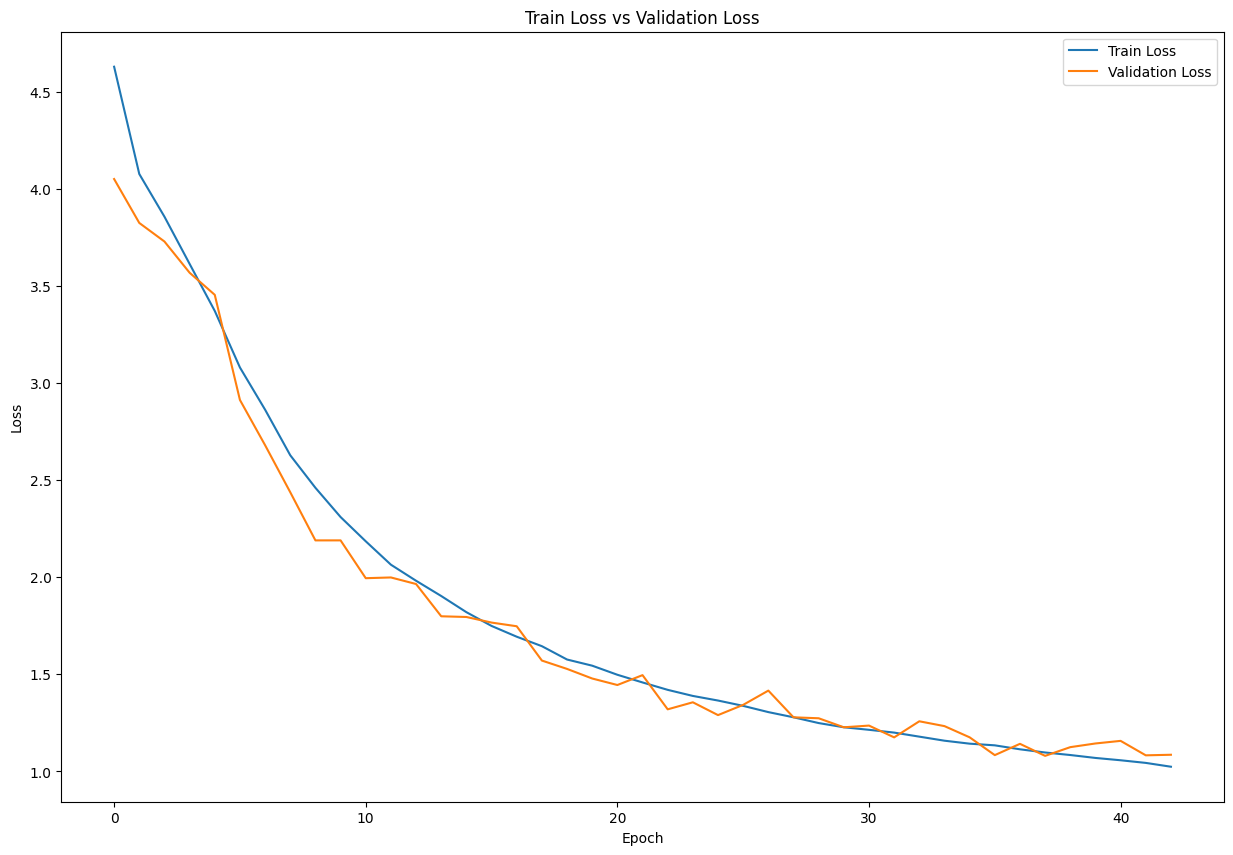

In [94]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [95]:
model.load_state_dict(torch.load('./.export/checkpoint-fe.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_30572\2604792629.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-fe.pt'

<All keys matched successfully>

In [96]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [97]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_seq, x_eng, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        x_eng = x_eng.to(device)
        targets = targets.to(device)
        outputs = model(x_seq, x_eng)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
        
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
residuals = all_preds - all_targets

Evaluation: 100%|██████████| 415/415 [00:01<00:00, 244.47it/s]


In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual Glucose vs Predicted Glucose")
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(residuals, bins=50)
plt.title("Residual")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [98]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [99]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [100]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
test_r2 = r2_score(all_targets, all_preds)
test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_pearson = pearson_r(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [101]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test Pearson r: {test_pearson:.4f}")
print(f"Test CCC: {test_ccc:.4f}")

Test RMSE: 1.0493
Test MAE: 0.7874
Test MARD: 0.1028
Test MBE: -0.1043
Test R²: 0.8767
Test Explained Variance: 0.8779
Test MAPE: 10.28%
Test Pearson r: 0.9395
Test CCC: 0.9389


### Inference

In [121]:
df_test = pd.read_csv("./.data/test_pp_fe.csv")

In [122]:
for col in df_test.columns:
    print(col)

id
bg-5:55
bg-5:50
bg-5:45
bg-5:40
bg-5:35
bg-5:30
bg-5:25
bg-5:20
bg-5:15
bg-5:10
bg-5:05
bg-5:00
bg-4:55
bg-4:50
bg-4:45
bg-4:40
bg-4:35
bg-4:30
bg-4:25
bg-4:20
bg-4:15
bg-4:10
bg-4:05
bg-4:00
bg-3:55
bg-3:50
bg-3:45
bg-3:40
bg-3:35
bg-3:30
bg-3:25
bg-3:20
bg-3:15
bg-3:10
bg-3:05
bg-3:00
bg-2:55
bg-2:50
bg-2:45
bg-2:40
bg-2:35
bg-2:30
bg-2:25
bg-2:20
bg-2:15
bg-2:10
bg-2:05
bg-2:00
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-5:55
insulin-5:50
insulin-5:45
insulin-5:40
insulin-5:35
insulin-5:30
insulin-5:25
insulin-5:20
insulin-5:15
insulin-5:10
insulin-5:05
insulin-5:00
insulin-4:55
insulin-4:50
insulin-4:45
insulin-4:40
insulin-4:35
insulin-4:30
insulin-4:25
insulin-4:20
insulin-4:15
insulin-4:10
insulin-4:05
insulin-4:00
insulin-3:55
insulin-3:50
insulin-3:45
insulin-3:40
insulin-3:35
insulin-3:30
insulin-3:25
insulin-3:20
insul

In [123]:
meta_data = ['id']

df_test_meta = df_test[meta_data]
df_test.drop(columns=meta_data, inplace=True)

In [124]:
print(df_test)

       bg-5:55   bg-5:50   bg-5:45   bg-5:40   bg-5:35   bg-5:30   bg-5:25  \
0    -1.224679 -1.224652 -1.225304 -1.304009 -1.381063 -1.458524 -1.415302   
1    -0.260055 -0.259895 -0.259882 -0.259958 -0.259708 -0.259550 -0.404094   
2    -0.692472 -0.692372 -0.692658 -0.526524 -0.359631 -0.192940  0.084841   
3    -0.692472 -0.692372 -0.692658 -0.615380 -0.537271 -0.459379 -0.437431   
4    -1.723622 -1.723664 -1.724660 -1.726072 -1.725241 -1.724962 -1.537536   
...        ...       ...       ...       ...       ...       ...       ...   
3639  0.638044  0.638327  0.638959  0.639702  0.706211  0.806205  0.773796   
3640  0.804358  0.704862  0.638959  0.539740  0.506365  0.439852  0.373758   
3641 -0.692472 -0.825442 -0.992271 -1.092977 -1.225627 -1.391914 -1.593097   
3642 -0.127003 -0.259895 -0.326463 -0.426562 -0.426246 -0.492684 -0.693011   
3643  1.037199  1.170606  1.338057  1.472722  1.538899  1.572216  1.573872   

       bg-5:20   bg-5:15   bg-5:10  ...  cals-0:05  cals-0:00  

In [125]:
for col in df_test.columns:
    print(col)

bg-5:55
bg-5:50
bg-5:45
bg-5:40
bg-5:35
bg-5:30
bg-5:25
bg-5:20
bg-5:15
bg-5:10
bg-5:05
bg-5:00
bg-4:55
bg-4:50
bg-4:45
bg-4:40
bg-4:35
bg-4:30
bg-4:25
bg-4:20
bg-4:15
bg-4:10
bg-4:05
bg-4:00
bg-3:55
bg-3:50
bg-3:45
bg-3:40
bg-3:35
bg-3:30
bg-3:25
bg-3:20
bg-3:15
bg-3:10
bg-3:05
bg-3:00
bg-2:55
bg-2:50
bg-2:45
bg-2:40
bg-2:35
bg-2:30
bg-2:25
bg-2:20
bg-2:15
bg-2:10
bg-2:05
bg-2:00
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-5:55
insulin-5:50
insulin-5:45
insulin-5:40
insulin-5:35
insulin-5:30
insulin-5:25
insulin-5:20
insulin-5:15
insulin-5:10
insulin-5:05
insulin-5:00
insulin-4:55
insulin-4:50
insulin-4:45
insulin-4:40
insulin-4:35
insulin-4:30
insulin-4:25
insulin-4:20
insulin-4:15
insulin-4:10
insulin-4:05
insulin-4:00
insulin-3:55
insulin-3:50
insulin-3:45
insulin-3:40
insulin-3:35
insulin-3:30
insulin-3:25
insulin-3:20
insulin-

In [126]:
class GDatasetInference(Dataset):
    def __init__(self, df):
        self.n_samples = len(df)
        data = df.values
        self.seq_data = data[:, :432].astype(np.float32).reshape(self.n_samples, 6, 72)
        self.eng_data = data[:, 432:440].astype(np.float32)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.seq_data[idx], self.eng_data[idx]

In [127]:
infer_test_dataset = GDatasetInference(df_test)
infer_test_loader = DataLoader(infer_test_dataset, batch_size=64, shuffle=False)

In [128]:
# def pad_to_8_features(x_eng):
#     if x_eng.shape[1] < 8:
#         padding = torch.zeros((x_eng.shape[0], 8 - x_eng.shape[1])).to(x_eng.device)
#         x_eng = torch.cat([x_eng, padding], dim=1)
#     return x_eng

In [129]:
model.eval()

all_preds = []
with torch.no_grad():
    for x_seq, x_eng in tqdm(infer_test_loader, desc="Inference"):
        x_seq = x_seq.to(device)
        x_eng = x_eng.to(device)
        outputs = model(x_seq, x_eng)
        all_preds.append(outputs.cpu().numpy())

all_preds = np.concatenate(all_preds)
df_predictions = pd.DataFrame(all_preds, columns=["bg+1:00"])

Inference: 100%|██████████| 57/57 [00:00<00:00, 111.15it/s]


In [130]:
df_results = pd.concat([df_test_meta.reset_index(drop=True), df_predictions], axis=1)
df_results.to_csv("./.export/test_submission_fe.csv", index=False)